# ロバストMDPの理論

参考
* [Sample Complexity of Robust Reinforcement Learning with a Generative Model](https://arxiv.org/abs/2112.01506)

シミュレータを使ったアプリケーションではしばしば、シミュレータ上の遷移確率$P^o$で方策を学習させて、実世界にデプロイすることを考えます。
しかし、実世界の遷移確率は$P^o$に対して必ずズレがあります。
ロバストMDPでは、$P^o$からのズレを含めた遷移確率の集合を$\mathcal{P}$として、$\mathcal{P}$の中の最悪ケースに対してもある程度の性能を保証するように学習することを目標にします。

今回はロバストMDP用のアルゴリズム``Robust Empirical Value Iteration (REVI)``を見て、そのサンプル効率を証明します(より詳細な証明は次回に回します)。
面倒なので定数係数は全部$\square$でまとめます。

## Tabular MDP

次の問題設定を考えます。

問題設定

* 更新の回数：$K$
* エフェクティブホライズン：$H:=1 / (1 - \gamma)$
* 遷移確率$P$での価値関数：$V_{\pi, P}(s)=\mathbb{E}_{\pi, P}\left[\sum_{t=0}^{\infty} \gamma^t r\left(s_t, a_t\right) \mid s_0=s\right]$
* $P$における最適なやつら：$V_P^*=\max _\pi V_{\pi, P}, \quad \pi_P^*=\underset{\pi}{\arg \max } V_{\pi, P}$
* ロバストなやつら：$V^\pi=\inf _{P \in \mathcal{P}} V_{\pi, P}, \quad V^*=\sup _\pi \inf _{P \in \mathcal{P}} V_{\pi, P}$
* 任意のベクトル$v$と集合$\mathcal{B}$について、$\sigma_{\mathcal{B}}(v)=\inf \left\{u^{\top} v: u \in \mathcal{B}\right\}$とする。
* 遷移確率のUncertainty set： $ \mathcal{P}=\otimes \mathcal{P}_{s, a}, \text { where, } \mathcal{P}_{s, a}=\left\{P_{s, a} \in[0,1]^{|\mathcal{S}|}: D\left(P_{s, a}, P_{s, a}^o\right) \leq c_r, \sum_{s^{\prime} \in \mathcal{S}} P_{s, a}\left(s^{\prime}\right)=1\right\}, $
    * ここで$D$は分布間の距離です。今回は特にf-ダイバージェンス$D_f(P \| Q)=\sum_x Q(x) f\left(\frac{P(x)}{Q(x)}\right)$を考えます。
* ロバストベルマン最適作用素：$T(V)(s)=\max _a(r(s, a)+ + \gamma \sigma_{\mathcal{P}_{s, a}}(V))$
    * これはContractionになっており、唯一の収束点は$V^*$である。(証明はTODO)

### REVIアルゴリズム

\begin{equation}
\begin{aligned}
& \text { 1: } \text { Input: Loop termination number } K \\
& \text { 2: } \text { Initialize: } Q_0=0 \\
& \text { 3: Compute the empirical uncertainty set } \widehat{\mathcal{P}}=\otimes \widehat{\mathcal{P}}_{s, a} \text {, where, } \widehat{\mathcal{P}}_{s, a}=\left\{P \in[0,1]^{\mathcal{S}} : D\left(P_{s, a}, \widehat{P}_{s, a}\right) \leq c_r, \sum_{s^{\prime} \in \mathcal{S}} P_{s, a}\left(s^{\prime}\right)=1\right\} \\
& \text { 4: } \text { for } k=0, \cdots, K-1 \text { do } \\
& \text { 5: } \quad V_k(s)=\max _a Q_k(s, a), \forall s \\
& \text { 6: } \quad Q_{k+1}(s, a)=r(s, a)+\gamma \sigma_{\widehat{\mathcal{P}}_{s, a}}\left(V_k\right), \forall(s, a) \\
& \text { 7: end for } \\
& \text { 8: Output: } \pi_K(s)=\arg \max _a Q_K(s, a), \forall s \in \mathcal{S}
\end{aligned}
\end{equation}

このアルゴリズムではGenerative model (シミュレータ)を仮定しています。なので探索が不要です。

実験してみましょう。
[Sample Complexity of Robust Reinforcement Learning with a Generative Model](https://arxiv.org/abs/2112.01506)のGambler's problemをちょっと変えて実験してみます。
([double chain MDP](reward_free_RL.ipynb)のマルチアクション版を考えます。）

In [38]:
import numpy as np
from itertools import product
from functools import partial
from typing import Optional, NamedTuple
import jax.numpy as jnp

def create_rew_P(S: int, A: int, head_prob: float):
    """ Gambler's Problem (報酬関数, 遷移確率) を作成します

    Args:
        S (int): 状態空間のサイズ
        A (int): 行動空間のサイズ
        head_prob (float): コインの表が出る確率

    Returns:
        rew (float): 報酬関数
        P (float): 遷移確率
    """

    # 一番右側の状態で1がもらえます
    # s=1を一番左側の状態として、s=0は吸収状態とします
    rew = np.zeros((S, A))
    rew[-1] = 1.0

    # コインの表が出ると右に、裏が出ると左に動きます。動く距離は行動の数に従います。
    P = np.zeros((S, A, S))
    for s, a in product(range(S), range(A)):
        if s == 0 or s == 1 or s == S - 1:  # 吸収状態か左端か右端
            P[s, a, 0] = 1
            continue
            
        next_s_down = max(1, s-a)  # 裏が出る
        next_s_up = min(s+a, S-a)  # 表が出る
        if next_s_down == next_s_up:
            P[s, a, next_s_down] = 1
        else:
            P[s, a, next_s_down] = 1 - head_prob
            P[s, a, next_s_up] = head_prob
    np.testing.assert_almost_equal(P.sum(axis=-1), 1)
    return jnp.array(rew), jnp.array(P)


class MDP(NamedTuple):
    S_array: np.array  # 状態空間
    A_array: np.array  # 行動空間
    gamma: float  # 割引率
    horizon: int  # エフェクティブホライゾン
    rew: float  # 報酬関数
    P: float  # 遷移確率
    optimal_Q: Optional[np.ndarray] = None  # 最適Q値
    optimal_Q_idx: Optional[np.ndarray] = None  # 後でplot用に使います

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_array)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_array)


S = 20
A = 8
S_array = np.arange(S)
A_array = np.arange(A)
gamma = 0.95
horizon = int(1 / (1 - gamma))
head_prob = 0.6

# Double chain MDP を作ります
rew, P = create_rew_P(S, A, head_prob)
double_chain = MDP(S_array, A_array, gamma, horizon, rew, P)

# 実験に便利な関数

実験の前に、いくつか便利な関数を導入します。

1. ``compute_greedy_policy``: Q関数 ($S \times A \to \mathcal{R}$) の貪欲方策を返します
2. ``compute_optimal_Q``: MDPの最適Q関数 $q_* : S \times A \to \mathcal{R}$ を返します。
3. ``compute_policy_Q``: 方策 $\pi$ のQ関数 $q_\pi : S \times A \to \mathcal{R}$ を返します。
4. ``sample_next_state``: $(s, a)$の次の状態をサンプルします。

In [39]:
import jax
from functools import partial
from tqdm import tqdm
from jax.random import PRNGKey
import random
from functools import partial


# >>>> 1 >>>>
@jax.jit
def compute_greedy_policy(Q: np.ndarray):
    greedy_policy = jnp.zeros_like(Q)
    S, A = Q.shape
    greedy_policy = greedy_policy.at[jnp.arange(S), Q.argmax(axis=1)].set(1)
    assert greedy_policy.shape == (S, A)
    return greedy_policy
# <<<< 1 <<<<


# >>>> 2 >>>>
@partial(jax.jit, static_argnames=("S", "A"))
def _compute_optimal_Q(mdp: MDP, S: int, A: int):

    def backup(optimal_Q):
        greedy_policy = compute_greedy_policy(optimal_Q)
        max_Q = (greedy_policy * optimal_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)
# <<<< 2 <<<<


# >>>> 3 >>>>
@jax.jit
def compute_policy_Q(mdp: MDP, policy: np.ndarray):
    S, A = policy.shape

    def backup(policy_Q):
        max_Q = (policy * policy_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon, body_fn, policy_Q)
# <<<< 3 <<<<


# >>>> 4 >>>>
@partial(jax.vmap, in_axes=(None, 0, 0))
def sample_next_state(mdp: MDP, key: PRNGKey, sa: int):
    """ sample next state according to the transition matrix P
    Args:
        mdp: MDP
        sa: int
    Returns:
        next_s: int
    """
    S, A, S = mdp.P.shape
    P = mdp.P.reshape(S * A, S)
    return jax.random.choice(key, mdp.S_array, p=P[sa])
# <<<< 4 <<<<

double_chain = double_chain._replace(optimal_Q=compute_optimal_Q(double_chain))

In [40]:
# ２つの遷移確率間のf-divergenceを返します
def compute_f_div(P1: np.ndarray, P2: np.ndarray, f, eps: float = 1e-7) -> np.ndarray:
    """ Compute f divergence of two transition matrixes
    Args:
        P1: transition matrix
        P2: transition matrix
        f: f-divergence function
        eps: small value to prevent nan
    Returns:
        f-divergence of each (s, a): SxA matrix
    """
    S, A, S = P1.shape
    div = (P2 * f((P1 + eps) / (P2 + eps))).sum(axis=-1)
    assert div.shape == (S, A)
    return div 


rew, P1 = create_rew_P(S, A, 0.1)
rew, P2 = create_rew_P(S, A, 0.6)

print("TV:", compute_f_div(P1, P2, lambda x: np.abs(x - 1) / 2).max())
print("X2:", compute_f_div(P1, P2, lambda x: (x - 1) ** 2).max())
print("KL:", compute_f_div(P1, P2, lambda x: x * np.log(x)).max())

TV: 0.49999994
X2: 1.0416663
KL: 0.550661


ロバストRLでは制約付き最適化問題を解く必要があります。
* $ \mathcal{P}=\otimes \mathcal{P}_{s, a}, \text { where, } \mathcal{P}_{s, a}=\left\{P_{s, a} \in[0,1]^{|\mathcal{S}|}: D\left(P_{s, a}, P_{s, a}^o\right) \leq c_r, \sum_{s^{\prime} \in \mathcal{S}} P_{s, a}\left(s^{\prime}\right)=1\right\}, $
* $\sigma_{\mathcal{\mathcal{P}_{s, a}}}(v)=\inf \left\{u^{\top} v: u \in \mathcal{\mathcal{P}_{s, a}}\right\}$

Scipyで実装します。(TODO: 双対問題とか考えると簡単かも)

In [41]:
from scipy.optimize import minimize

P_robust = np.zeros((S, A, S))
v = double_chain.optimal_Q.max(axis=-1)
P_div_tol = 0.1

for s, a in product(range(S), range(A)):
    base_p_sa = P1[s, a]
    fun = lambda p_sa: p_sa @ v
    TV_const = lambda p_sa: np.sum(p_sa * (np.abs((base_p_sa + 1e-7) / (p_sa + 1e-7) - 1) / 2)) - P_div_tol
    prob_const = lambda p_sa: np.sum(p_sa) - 1.0
    bnds = [(0, None) for _ in range(S)]
    cons = ({'type': 'ineq', 'fun': TV_const}, {'type': 'eq', 'fun': prob_const})
    res = minimize(fun, np.zeros(S), method='SLSQP', constraints=cons, bounds=bnds)
    P_robust[s, a] = res.x


In [48]:
from scipy.optimize import minimize
from tqdm import tqdm

def compute_robust_optimal_Q(mdp: MDP, P_div_tol: float=0.1):
    S, A = mdp.S, mdp.A
    optimal_Q = np.zeros((S, A))

    for h in tqdm(range(mdp.horizon)):
        P_robust = np.zeros((S, A, S))
        max_Q = optimal_Q.max(axis=1)

        # 最悪ケースのPを計算します
        for s, a in product(range(S), range(A)):
            base_p_sa = P1[s, a]
            fun = lambda p_sa: p_sa @ v
            TV_const = lambda p_sa: np.sum(p_sa * (np.abs((base_p_sa + 1e-7) / (p_sa + 1e-7) - 1) / 2)) - P_div_tol
            prob_const = lambda p_sa: np.sum(p_sa) - 1.0
            bnds = [(0, None) for _ in range(S)]
            cons = ({'type': 'ineq', 'fun': TV_const}, {'type': 'eq', 'fun': prob_const})
            res = minimize(fun, np.zeros(S), method='SLSQP', constraints=cons, bounds=bnds)
            P_robust[s, a] = res.x

        next_v = P_robust @ max_Q
        assert next_v.shape == (S, A)
        optimal_Q = mdp.rew + mdp.gamma * next_v

    return optimal_Q

In [49]:
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm

 
def VI(mdp: MDP, true_mdp: MDP):
    Q_table = compute_optimal_Q(mdp)
    greedy_policy = compute_greedy_policy(Q_table)

    Q_pi = compute_policy_Q(true_mdp, greedy_policy)
    optimality_gap = np.abs(true_mdp.optimal_Q - Q_pi).max()
    return optimality_gap


def robust_VI(mdp: MDP, true_mdp: MDP, P_div_tol: float):
    Q_table = compute_robust_optimal_Q(mdp, P_div_tol)
    greedy_policy = compute_greedy_policy(Q_table)

    Q_pi = compute_policy_Q(true_mdp, greedy_policy)
    optimality_gap = np.abs(true_mdp.optimal_Q - Q_pi).max()
    return optimality_gap



def empirical_VI(mdp: MDP, true_mdp: MDP, N: int):
    prng_key = PRNGKey(0)
    S, A = mdp.S, mdp.A

    # generative_modelを使ってPを推定します
    P_approx = np.zeros((S * A, S))
    SA_array = np.arange(S * A)
    for _ in range(N):
        _, prng_key = jax.random.split(prng_key)
        keys = jax.random.split(prng_key, num=S * A)
        next_s = sample_next_state(double_chain, keys, SA_array)
        P_approx[SA_array, next_s] += 1
    P_approx = P_approx / N
    P_approx = P_approx.reshape(S, A, S)

    # 推定したPのもとでValue iterationをします。
    approx_mdp = mdp._replace(P=P_approx)
    Q_table = compute_optimal_Q(approx_mdp)
    greedy_policy = compute_greedy_policy(Q_table)

    Q_pi = compute_policy_Q(true_mdp, greedy_policy)
    optimality_gap = np.abs(true_mdp.optimal_Q - Q_pi).max()
    return optimality_gap


def empirical_robust_VI(mdp: MDP, true_mdp: MDP, N: int, P_div_tol):
    prng_key = PRNGKey(0)
    S, A = mdp.S, mdp.A

    # generative_modelを使ってPを推定します
    P_approx = np.zeros((S * A, S))
    SA_array = np.arange(S * A)
    for _ in range(N):
        _, prng_key = jax.random.split(prng_key)
        keys = jax.random.split(prng_key, num=S * A)
        next_s = sample_next_state(double_chain, keys, SA_array)
        P_approx[SA_array, next_s] += 1
    P_approx = P_approx / N
    P_approx = P_approx.reshape(S, A, S)

    # 推定したPのもとでrobust Value iterationをします。
    approx_mdp = mdp._replace(P=P_approx)
    Q_table = compute_robust_optimal_Q(approx_mdp, P_div_tol)
    greedy_policy = compute_greedy_policy(Q_table)

    Q_pi = compute_policy_Q(true_mdp, greedy_policy)
    optimality_gap = np.abs(true_mdp.optimal_Q - Q_pi).max()
    return optimality_gap



N = 10
P_div_tol = 1e-3

head_probs = []
VI_gaps = []
empirical_VI_gaps = []
robust_VI_gaps = []
empirical_robust_VI_gaps = []

for head_prob in tqdm(range(3, 10)):
    head_prob = head_prob / 10
    rew, P = create_rew_P(S, A, head_prob)
    true_double_chain = MDP(S_array, A_array, gamma, horizon, rew, P)
    true_double_chain = true_double_chain._replace(optimal_Q=compute_optimal_Q(true_double_chain))
    VI_gaps.append(VI(double_chain, true_double_chain))
    empirical_VI_gaps.append(empirical_VI(double_chain, true_double_chain, N))
    robust_VI_gaps.append(robust_VI(double_chain, true_double_chain, P_div_tol))
    empirical_robust_VI_gaps.append(empirical_robust_VI(double_chain, true_double_chain, N, P_div_tol))
    head_probs.append(head_prob)

100%|██████████| 7/7 [05:02<00:00, 43.22s/it]


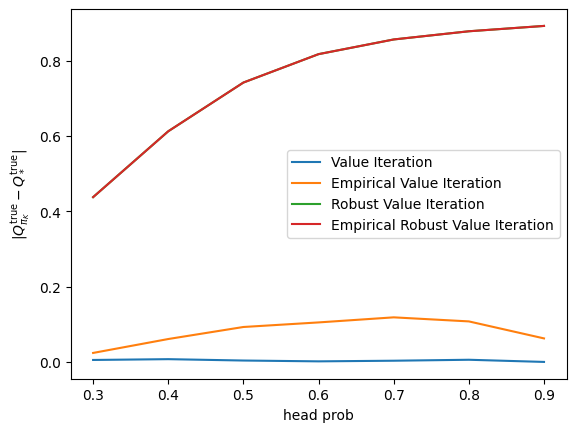

In [46]:
plt.plot(head_probs, VI_gaps, label="Value Iteration")
plt.plot(head_probs, empirical_VI_gaps, label="Empirical Value Iteration")
plt.plot(head_probs, robust_VI_gaps, label="Robust Value Iteration")
plt.plot(head_probs, empirical_robust_VI_gaps, label="Empirical Robust Value Iteration")
plt.ylabel(r"$\|Q_{\pi_K}^{\mathrm{true}} - Q_*^{\mathrm{true}}\|$")
plt.xlabel("head prob")
plt.legend()

うーん、なんか結果が微妙ですね。評価も微妙ですが、そもそも計算が重くてあんまり効率よくないですね（全ての状態行動対について制約付き最適化問題を解く必要があるので）。
TODO: 真の環境での$Q_{\pi_K}$と$Q_*$を比較するのは微妙かも。一応0.6付近で真のValue Iterationは強くなるのでOK？